In [120]:
import pandas as pd
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import keras as K
import tensorflow as tf
import os, json
from scipy import misc
import cv2
import pickle

In [2]:
from cnn_builder import get_model

In [3]:
IMAGE_DATA_PATH = './data'

In [4]:
image_data = pd.read_csv(os.path.join(IMAGE_DATA_PATH, 'driving_log.csv'))

In [5]:
image_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8036 entries, 0 to 8035
Data columns (total 7 columns):
center      8036 non-null object
left        8036 non-null object
right       8036 non-null object
steering    8036 non-null float64
throttle    8036 non-null float64
brake       8036 non-null float64
speed       8036 non-null float64
dtypes: float64(4), object(3)
memory usage: 439.5+ KB


In [6]:
image_data.head()

,center,left,right,steering,throttle,brake,speed
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0,0.0,0.0,22.148290
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.879630
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0.0,0.0,0.0,1.453011
3,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0.0,0.0,0.0,1.438419
4,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0.0,0.0,0.0,1.418236


### Train-test split 

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
ind_train, ind_test = train_test_split(np.array(range(len(image_data))), train_size=0.8, random_state = 42)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [17]:
train_df = image_data.loc[ind_train]
test_df = image_data.loc[ind_test]

### Training the models

In [21]:
def generator_df(samples_df_, source_path='data', data_columns = ['center'], val_column = 'steering', batch_size=4):
# yields batches from dataframe samples_df: ['images', 'steering']
    samples_df = samples_df_.copy()
    num_samples = len(samples_df)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples_df)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples_df[offset:offset+batch_size]

            images = None
            angles = np.array([], dtype='float32')
            for i, batch_sample in batch_samples.iterrows():
                name = batch_sample[np.random.choice(data_columns, 1)].values[0]
                name = name.strip()
                center_image = cv2.imread(os.path.join(source_path,name))
                if center_image is not None:
                    center_angle = batch_sample[val_column]
                    if images is None:
                        images = center_image[np.newaxis]
                    else:
                        images = np.vstack([images, center_image[np.newaxis]])
                    angles = np.append(angles, center_angle)

            yield images, angles

In [22]:
def predict_generator_df(samples_df_, source_path='data', data_columns = ['center'], batch_size=4):
# yields batches for predictions, no shuffling
    samples_df = samples_df_.copy()
    num_samples = len(samples_df)
    while 1: # Loop forever so the generator never terminates
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples_df[offset:offset+batch_size]

            images = None
            angles = np.array([], dtype='float32')
            for i, batch_sample in batch_samples.iterrows():
                name = batch_sample[np.random.choice(data_columns, 1)].values[0]
                name = name.strip()
                center_image = cv2.imread(os.path.join(source_path,name))
                center_angle = batch_sample['steering']
                if images is None:
                    images = center_image[np.newaxis]
                else:
                    images = np.vstack([images, center_image[np.newaxis]])
                angles = np.append(angles, center_angle)

            yield images

In [23]:
BATCH_SIZE = 8
train_generator = generator_df(train_df, batch_size=BATCH_SIZE)
val_generator = generator_df(test_df, batch_size=BATCH_SIZE)

#### Training VGG16-based model

In [25]:
MODEL_SAVING_PATH = 'trained_weights'
from keras.callbacks import ModelCheckpoint

In [31]:
saving_path = os.path.join(MODEL_SAVING_PATH, 'vgg16', 'weights_vgg16.{epoch:02d}-{val_loss:.4f}.hdf5')
saver = ModelCheckpoint(saving_path, verbose=1, save_weights_only=True)

In [32]:
model_vgg16 = get_model('VGG16')
model_vgg16.compile(loss='mse', optimizer='adam')

In [33]:
history_vgg16 = model_vgg16.fit_generator(train_generator, steps_per_epoch=len(train_df)/BATCH_SIZE, validation_data=val_generator,
                                       validation_steps=len(test_df)/BATCH_SIZE, epochs=10, callbacks=[saver])

Epoch 1/10
804/803 [==============================] - 23s 29ms/step - loss: 0.2219 - val_loss: 0.0153

Epoch 00001: saving model to trained_weights/vgg16/weights_vgg16.01-0.0153.hdf5
Epoch 2/10
804/803 [==============================] - 19s 24ms/step - loss: 0.0140 - val_loss: 0.0200

Epoch 00002: saving model to trained_weights/vgg16/weights_vgg16.02-0.0200.hdf5
Epoch 3/10
804/803 [==============================] - 19s 24ms/step - loss: 0.0121 - val_loss: 0.0109

Epoch 00003: saving model to trained_weights/vgg16/weights_vgg16.03-0.0109.hdf5
Epoch 4/10
804/803 [==============================] - 19s 24ms/step - loss: 0.0099 - val_loss: 0.0231

Epoch 00004: saving model to trained_weights/vgg16/weights_vgg16.04-0.0231.hdf5
Epoch 5/10
804/803 [==============================] - 19s 24ms/step - loss: 0.0087 - val_loss: 0.0095

Epoch 00005: saving model to trained_weights/vgg16/weights_vgg16.05-0.0095.hdf5
Epoch 6/10
804/803 [==============================] - 19s 24ms/step - loss: 0.0078 - 

#### Training NVIDIA-style model

In [34]:
saving_path = os.path.join(MODEL_SAVING_PATH, 'nvidia', 'weights_nvidia.{epoch:02d}-{val_loss:.4f}.hdf5')
saver = ModelCheckpoint(saving_path, verbose=1, save_weights_only=True)

In [35]:
model_nvidia = get_model('NVIDIA')
model_nvidia.compile(loss='mse', optimizer='adam')

In [36]:
history_nvidia = model_nvidia.fit_generator(train_generator, steps_per_epoch=len(train_df)/BATCH_SIZE, validation_data=val_generator,
                                       validation_steps=len(test_df)/BATCH_SIZE, epochs=10, callbacks=[saver])

Epoch 1/10
804/803 [==============================] - 14s 18ms/step - loss: 0.6236 - val_loss: 0.0154

Epoch 00001: saving model to trained_weights/nvidia/weights_nvidia.01-0.0154.hdf5
Epoch 2/10
804/803 [==============================] - 14s 17ms/step - loss: 0.0098 - val_loss: 0.0135

Epoch 00002: saving model to trained_weights/nvidia/weights_nvidia.02-0.0135.hdf5
Epoch 3/10
804/803 [==============================] - 14s 17ms/step - loss: 0.0052 - val_loss: 0.0154

Epoch 00003: saving model to trained_weights/nvidia/weights_nvidia.03-0.0154.hdf5
Epoch 4/10
804/803 [==============================] - 14s 17ms/step - loss: 0.0032 - val_loss: 0.0142

Epoch 00004: saving model to trained_weights/nvidia/weights_nvidia.04-0.0142.hdf5
Epoch 5/10
804/803 [==============================] - 14s 17ms/step - loss: 0.0036 - val_loss: 0.0142

Epoch 00005: saving model to trained_weights/nvidia/weights_nvidia.05-0.0142.hdf5
Epoch 6/10
804/803 [==============================] - 14s 17ms/step - loss:

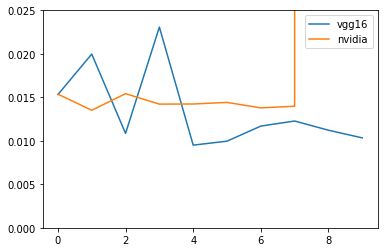

In [45]:
plt.plot(history_vgg16.history['val_loss'])
plt.plot(history_nvidia.history['val_loss'])
plt.ylim((0,0.025))
plt.legend(['vgg16', 'nvidia'])
plt.show()

### Load pretrained model (for experiments)

In [18]:
from keras.models import load_model

In [47]:
model_vgg16.load_weights('trained_weights/vgg16/weights_vgg16.05-0.0095.hdf5')

### Try to use left and right images

In [46]:
center_generator = predict_generator_df(train_df, source_path='data', data_columns = ['center'], batch_size=BATCH_SIZE)
left_generator = predict_generator_df(train_df, data_columns=['left'], batch_size=BATCH_SIZE)
right_generator = predict_generator_df(train_df, data_columns=['right'], batch_size=BATCH_SIZE)

In [48]:
center_predictions = model_vgg16.predict_generator(center_generator, steps=len(train_df)/BATCH_SIZE)

In [50]:
center_predictions = center_predictions.flatten()

In [52]:
left_predictions = model_vgg16.predict_generator(left_generator, steps=len(train_df)/BATCH_SIZE).flatten()

In [53]:
right_predictions = model_vgg16.predict_generator(right_generator, steps=len(train_df)/BATCH_SIZE).flatten()

#### Here we calculate correction factors between predictions

In [55]:
left_delta = np.mean(center_predictions - left_predictions)
right_delta = np.mean(center_predictions - right_predictions)

In [56]:
print(left_delta, right_delta)

-0.05206264 0.059707746


#### Make extended dataset with all images used

In [57]:
left_steering = train_df['steering'].values - left_delta
right_steering = train_df['steering'].values - right_delta

In [60]:
train_df_ext = train_df
train_df_ext['left_steering'] = train_df['steering'] - left_delta
train_df_ext['right_steering'] = train_df['steering'] - right_delta
train_df_ext.head()

,center,left,right,steering,throttle,brake,speed,left_steering,right_steering
3422,IMG/center_2016_12_01_13_38_25_085.jpg,IMG/left_2016_12_01_13_38_25_085.jpg,IMG/right_2016_12_01_13_38_25_085.jpg,0.000000,0.985533,0.0,30.186300,0.052063,-0.059708
6214,IMG/center_2016_12_01_13_43_37_055.jpg,IMG/left_2016_12_01_13_43_37_055.jpg,IMG/right_2016_12_01_13_43_37_055.jpg,0.000000,0.985533,0.0,30.186570,0.052063,-0.059708
3501,IMG/center_2016_12_01_13_38_33_072.jpg,IMG/left_2016_12_01_13_38_33_072.jpg,IMG/right_2016_12_01_13_38_33_072.jpg,0.000000,0.000000,0.0,9.823975,0.052063,-0.059708
2688,IMG/center_2016_12_01_13_37_10_714.jpg,IMG/left_2016_12_01_13_37_10_714.jpg,IMG/right_2016_12_01_13_37_10_714.jpg,0.000000,0.985533,0.0,30.186650,0.052063,-0.059708
5023,IMG/center_2016_12_01_13_41_36_264.jpg,IMG/left_2016_12_01_13_41_36_264.jpg,IMG/right_2016_12_01_13_41_36_264.jpg,-0.135712,0.985533,0.0,30.185320,-0.083649,-0.195420


In [62]:
train_df_joint = train_df_ext[['center', 'steering']].rename(columns={'center': 'image', 'steering': 'value'})
train_df_joint = pd.concat([train_df_joint,
                           train_df_ext[['left', 'left_steering']].rename(columns={'left': 'image', 'left_steering': 'value'})],
                          ignore_index=True)
train_df_joint = pd.concat([train_df_joint,
                           train_df_ext[['right', 'right_steering']].rename(columns={'right': 'image', 'right_steering': 'value'})],
                          ignore_index=True)
train_df_joint.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19284 entries, 0 to 19283
Data columns (total 2 columns):
image    19284 non-null object
value    19284 non-null float64
dtypes: float64(1), object(1)
memory usage: 301.4+ KB


### Train VGG16 model on joint dataset

In [63]:
train_generator_joint = generator_df(train_df_joint, data_columns = ['image'], val_column = 'value', batch_size=BATCH_SIZE)

In [64]:
saving_path = os.path.join(MODEL_SAVING_PATH, 'vgg16_joint', 'weights_vgg16_joint.{epoch:02d}-{val_loss:.4f}.hdf5')
saver = ModelCheckpoint(saving_path, verbose=1, save_weights_only=True)

In [67]:
model_vgg16_joint = get_model('VGG16')
model_vgg16_joint.compile(optimizer='adam', loss='mse')

In [68]:
history_vgg16_joint = model_vgg16_joint.fit_generator(train_generator_joint, steps_per_epoch=len(train_df_joint)/BATCH_SIZE,
                                                        validation_data=val_generator,
                                       validation_steps=len(test_df)/BATCH_SIZE, epochs=10, callbacks=[saver])

Epoch 1/10
2411/2410 [==============================] - 46s 19ms/step - loss: 0.0665 - val_loss: 0.0099

Epoch 00001: saving model to trained_weights/vgg16_joint/weights_vgg16_joint.01-0.0099.hdf5
Epoch 2/10
2411/2410 [==============================] - 46s 19ms/step - loss: 0.0095 - val_loss: 0.0095

Epoch 00002: saving model to trained_weights/vgg16_joint/weights_vgg16_joint.02-0.0095.hdf5
Epoch 3/10
2411/2410 [==============================] - 46s 19ms/step - loss: 0.0085 - val_loss: 0.0089

Epoch 00003: saving model to trained_weights/vgg16_joint/weights_vgg16_joint.03-0.0089.hdf5
Epoch 4/10
2411/2410 [==============================] - 46s 19ms/step - loss: 0.0085 - val_loss: 0.0093

Epoch 00004: saving model to trained_weights/vgg16_joint/weights_vgg16_joint.04-0.0093.hdf5
Epoch 5/10
2411/2410 [==============================] - 46s 19ms/step - loss: 0.0082 - val_loss: 0.0090

Epoch 00005: saving model to trained_weights/vgg16_joint/weights_vgg16_joint.05-0.0090.hdf5
Epoch 6/10
2411

### Train NVIDIA-model on joint dataset

In [69]:
saving_path = os.path.join(MODEL_SAVING_PATH, 'nvidia_joint', 'weights_nvidia_joint.{epoch:02d}-{val_loss:.4f}.hdf5')
saver = ModelCheckpoint(saving_path, verbose=1, save_weights_only=True)

In [70]:
model_nvidia_joint = get_model('NVIDIA')
model_nvidia_joint.compile(optimizer='adam', loss='mse')

In [71]:
history_nvidia_joint = model_nvidia_joint.fit_generator(train_generator_joint, steps_per_epoch=len(train_df_joint)/BATCH_SIZE,
                                                        validation_data=val_generator,
                                       validation_steps=len(test_df)/BATCH_SIZE, epochs=10, callbacks=[saver])

Epoch 1/10
2411/2410 [==============================] - 37s 15ms/step - loss: 0.3003 - val_loss: 0.0110

Epoch 00001: saving model to trained_weights/nvidia_joint/weights_nvidia_joint.01-0.0110.hdf5
Epoch 2/10
2411/2410 [==============================] - 36s 15ms/step - loss: 0.0094 - val_loss: 0.0108

Epoch 00002: saving model to trained_weights/nvidia_joint/weights_nvidia_joint.02-0.0108.hdf5
Epoch 3/10
2411/2410 [==============================] - 36s 15ms/step - loss: 0.0090 - val_loss: 0.0145

Epoch 00003: saving model to trained_weights/nvidia_joint/weights_nvidia_joint.03-0.0145.hdf5
Epoch 4/10
2411/2410 [==============================] - 36s 15ms/step - loss: 0.0086 - val_loss: 0.0194

Epoch 00004: saving model to trained_weights/nvidia_joint/weights_nvidia_joint.04-0.0194.hdf5
Epoch 5/10
2411/2410 [==============================] - 36s 15ms/step - loss: 0.0102 - val_loss: 0.0123

Epoch 00005: saving model to trained_weights/nvidia_joint/weights_nvidia_joint.05-0.0123.hdf5
Epoch

## Make flipping

In [87]:
flipped_img_path = os.path.join( 'IMG', 'flipped')

In [88]:
filenames = []
values = []
for i, row in train_df_joint.iterrows():
    imgname = row['image']
    steering = row['value']
    imgname = imgname.strip()
    #img = cv2.imread(os.path.join('data',imgname))
    #img = cv2.flip(img, flipCode=1)
    saving_name = os.path.join(flipped_img_path, os.path.split(imgname)[-1])
    #cv2.imwrite(saving_name, img)
    filenames.append(saving_name)
    values.append(-1*steering)

In [89]:
flipped_df = pd.DataFrame({'image': filenames, 'value': values})

In [90]:
flipped_df = pd.concat([train_df_joint, flipped_df], ignore_index=True)
flipped_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38568 entries, 0 to 38567
Data columns (total 2 columns):
image    38568 non-null object
value    38568 non-null float64
dtypes: float64(1), object(1)
memory usage: 602.7+ KB


In [92]:
flipped_df.tail()

,image,value
38563,IMG/flipped/right_2016_12_01_13_41_56_808.jpg,0.059708
38564,IMG/flipped/right_2016_12_01_13_42_13_486.jpg,0.059708
38565,IMG/flipped/right_2016_12_01_13_34_05_436.jpg,-0.069032
38566,IMG/flipped/right_2016_12_01_13_45_57_896.jpg,0.059708
38567,IMG/flipped/right_2016_12_01_13_45_24_146.jpg,0.059708


### Training models on joint and flipped dataset

In [93]:
train_generator_flipped = generator_df(flipped_df, data_columns=['image'], val_column='value', batch_size=BATCH_SIZE)

In [99]:
model_vgg16_flipped = get_model('VGG16')
model_vgg16_flipped.compile(optimizer='adam', loss='mse')

In [95]:
model_nvidia_flipped = get_model('NVIDIA')
model_nvidia_flipped.compile(optimizer='adam', loss='mse')

In [96]:
saving_path = os.path.join(MODEL_SAVING_PATH, 'vgg16_flipped', 'weights_vgg16_flipped.{epoch:02d}-{val_loss:.4f}.hdf5')
saver_vgg = ModelCheckpoint(saving_path, verbose=1, save_weights_only=True)

In [97]:
saving_path = os.path.join(MODEL_SAVING_PATH, 'nvidia_flipped', 'weights_nvidia_flipped.{epoch:02d}-{val_loss:.4f}.hdf5')
saver_nvidia = ModelCheckpoint(saving_path, verbose=1, save_weights_only=True)

In [100]:
history_vgg16_flipped = model_vgg16_flipped.fit_generator(train_generator_flipped, steps_per_epoch=len(flipped_df)/BATCH_SIZE,
                                     validation_data = val_generator, validation_steps=len(test_df)/BATCH_SIZE,
                                 callbacks=[saver_vgg], epochs=10)

Epoch 1/10
4821/4821 [==============================] - 101s 21ms/step - loss: 0.0274 - val_loss: 0.0105

Epoch 00001: saving model to trained_weights/vgg16_flipped/weights_vgg16_flipped.01-0.0105.hdf5
Epoch 2/10
4821/4821 [==============================] - 100s 21ms/step - loss: 0.0093 - val_loss: 0.0097

Epoch 00002: saving model to trained_weights/vgg16_flipped/weights_vgg16_flipped.02-0.0097.hdf5
Epoch 3/10
4821/4821 [==============================] - 100s 21ms/step - loss: 0.0089 - val_loss: 0.0088

Epoch 00003: saving model to trained_weights/vgg16_flipped/weights_vgg16_flipped.03-0.0088.hdf5
Epoch 4/10
4821/4821 [==============================] - 100s 21ms/step - loss: 0.0084 - val_loss: 0.0086

Epoch 00004: saving model to trained_weights/vgg16_flipped/weights_vgg16_flipped.04-0.0086.hdf5
Epoch 5/10
4821/4821 [==============================] - 100s 21ms/step - loss: 0.0080 - val_loss: 0.0086

Epoch 00005: saving model to trained_weights/vgg16_flipped/weights_vgg16_flipped.05-0.

In [101]:
history_nvidia_flipped = model_nvidia_flipped.fit_generator(train_generator_flipped, steps_per_epoch=len(flipped_df)/BATCH_SIZE,
                                     validation_data = val_generator, validation_steps=len(test_df)/BATCH_SIZE,
                                 callbacks=[saver_nvidia], epochs=10)

Epoch 1/10
4821/4821 [==============================] - 75s 15ms/step - loss: 0.0926 - val_loss: 0.0127

Epoch 00001: saving model to trained_weights/nvidia_flipped/weights_nvidia_flipped.01-0.0127.hdf5
Epoch 2/10
4821/4821 [==============================] - 73s 15ms/step - loss: 0.0121 - val_loss: 0.0139

Epoch 00002: saving model to trained_weights/nvidia_flipped/weights_nvidia_flipped.02-0.0139.hdf5
Epoch 3/10
4821/4821 [==============================] - 73s 15ms/step - loss: 0.0129 - val_loss: 0.0166

Epoch 00003: saving model to trained_weights/nvidia_flipped/weights_nvidia_flipped.03-0.0166.hdf5
Epoch 4/10
4821/4821 [==============================] - 74s 15ms/step - loss: 1401.7355 - val_loss: 1.6685

Epoch 00004: saving model to trained_weights/nvidia_flipped/weights_nvidia_flipped.04-1.6685.hdf5
Epoch 5/10
4821/4821 [==============================] - 73s 15ms/step - loss: 1.3187 - val_loss: 0.3458

Epoch 00005: saving model to trained_weights/nvidia_flipped/weights_nvidia_flipp

### Try add another dense layer

In [106]:
from vgg16_e import get_VGG16_e

In [107]:
model_vgg16e = get_VGG16_e()

In [108]:
model_vgg16e.compile(optimizer='adam', loss='mse')

In [109]:
saving_path = os.path.join(MODEL_SAVING_PATH, 'vgg16e_flipped', 'weights_vgg16e_flipped.{epoch:02d}-{val_loss:.4f}.hdf5')
saver_vgg = ModelCheckpoint(saving_path, verbose=1, save_weights_only=True)

In [110]:
history_vgg16e_flipped = model_vgg16e.fit_generator(train_generator_flipped, steps_per_epoch=len(flipped_df)/BATCH_SIZE,
                                     validation_data = val_generator, validation_steps=len(test_df)/BATCH_SIZE,
                                 callbacks=[saver_vgg], epochs=10)

Epoch 1/10
4821/4821 [==============================] - 107s 22ms/step - loss: 0.2014 - val_loss: 0.0108

Epoch 00001: saving model to trained_weights/vgg16e_flipped/weights_vgg16e_flipped.01-0.0108.hdf5
Epoch 2/10
4821/4821 [==============================] - 106s 22ms/step - loss: 0.0119 - val_loss: 0.0116

Epoch 00002: saving model to trained_weights/vgg16e_flipped/weights_vgg16e_flipped.02-0.0116.hdf5
Epoch 3/10
4821/4821 [==============================] - 106s 22ms/step - loss: 0.0113 - val_loss: 0.0113

Epoch 00003: saving model to trained_weights/vgg16e_flipped/weights_vgg16e_flipped.03-0.0113.hdf5
Epoch 4/10
4821/4821 [==============================] - 106s 22ms/step - loss: 0.0094 - val_loss: 0.0097

Epoch 00004: saving model to trained_weights/vgg16e_flipped/weights_vgg16e_flipped.04-0.0097.hdf5
Epoch 5/10
4821/4821 [==============================] - 105s 22ms/step - loss: 0.0088 - val_loss: 0.0089

Epoch 00005: saving model to trained_weights/vgg16e_flipped/weights_vgg16e_fli

In [112]:
with open(os.path.join('train_history', 'history_vgg16.json'), 'w') as f:
    json.dump(history_vgg16.history, f)

In [114]:
with open(os.path.join('train_history', 'history_nvidia.json'), 'w') as f:
    json.dump(history_nvidia.history, f)

In [115]:
with open(os.path.join('train_history', 'history_vgg16_joint.json'), 'w') as f:
    json.dump(history_vgg16_joint.history, f)

In [116]:
with open(os.path.join('train_history', 'history_vgg16_flipped.json'), 'w') as f:
    json.dump(history_vgg16_flipped.history, f)

In [117]:
with open(os.path.join('train_history', 'history_vgg16e_flipped.json'), 'w') as f:
    json.dump(history_vgg16e_flipped.history, f)

In [118]:
with open(os.path.join('train_history', 'history_nvidia_joint.json'), 'w') as f:
    json.dump(history_nvidia_joint.history, f)

In [119]:
with open(os.path.join('train_history', 'history_nvidia_flipped.json'), 'w') as f:
    json.dump(history_nvidia_flipped.history, f)

In [125]:
with open(os.path.join('datasets', 'train_df.p'), 'wb') as f:
    pickle.dump(train_df, f)

In [126]:
with open(os.path.join('datasets', 'train_df_joint.p'), 'wb') as f:
    pickle.dump(train_df_joint, f)

In [128]:
with open(os.path.join('datasets', 'train_df_flipped.p'), 'wb') as f:
    pickle.dump(flipped_df, f)

In [129]:
with open(os.path.join('datasets', 'test_df.p'), 'wb') as f:
    pickle.dump(test_df, f)